# Walkthrough

In this walkthrough, we'll create our very own graphs using Pargraph.

## Defining `delayed` functions

`delayed` functions are pure and inseparable. These functions can be composed to implement graph functions and their pure nature allows them to be scheduled and executed concurrently across cores and/or hosts.

In a graph, `delayed` functions represent the nodes and the edges represent the dependencies between them.

### Example: NYC Yellow Taxi Fare Totals by Year

NYC Taxi and Limousine Commission publishes [data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) of every taxi trip since 2009. Each data file is in the [Parquet format](https://parquet.apache.org/) and contains each trip taken in a given month. Loading each file and processing them sequentially takes a very long time, so to speed it up we would like to load and process the files in parallel then perform an aggregation afterward.

Here are some functions that we will need, defined as `delayed` functions:

In [1]:
import pandas as pd
from pargraph import delayed


@delayed
def get_total_amount_sum(file_url, unit):
    """
    Calculate the sum of the 'total_amount' column from a Parquet file and divide it by a given unit.

    :param file_url: The URL of the Parquet file
    :param unit: The unit to divide the total amount sum by
    :return: The sum of the 'total_amount' column divided by the given unit
    """
    return (
        pd.read_parquet(file_url, columns=["total_amount"])["total_amount"].sum() / unit
    )


@delayed
def add(*args):
    """
    Calculate the sum of all the arguments provided.

    :param args: A variable number of arguments to be summed
    :return: The sum of all arguments
    """
    return sum(args)


@delayed
def collect_result(*results):
    """
    Collect results into a pandas Series, using every other element as the index and the remaining elements as the values.

    :param results: A variable number of arguments where even-indexed elements are used as the index and odd-indexed elements as the values
    :return: A pandas Series with the specified index and values
    """
    return pd.Series(results[1::2], index=results[0::2])

A `delayed` function retains the same call semantics as a normal Python function:

In [2]:
add(1, 2)

3

## Defining `graph` functions

`graph` functions contain a combination of `graph` and `delayed` functions. `graph` functions are to `delayed` functions as molecules are to atoms.

In [3]:
from pargraph import graph

URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02}.parquet"


@graph
def nyc_yellow_taxi_fare_total_for_year(year, unit):
    """
    Calculate the total fare amount for a given year by summing the total amounts from each month.

    :param year: The year for which to calculate the total fare amount
    :param unit: The unit to divide the total amount sum by
    :return: Total fare amount for the given year
    """
    return add(
        *(
            get_total_amount_sum(URL.format(year=year, month=month), unit)
            for month in range(1, 13)
        )
    )

A `graph` function retains the same call semantics as a normal Python function:

In [4]:
nyc_yellow_taxi_fare_total_for_year(year=2024, unit=1_000_000)

np.float64(1145.8691257199998)

## Converting to graphs

Using `to_graph()`, we can generate a graph representation of the pipeline function we've created:

In [ ]:
nyc_yellow_taxi_fare_total_for_year.to_graph(year=2024)

Graphs can also be converted to a task graph using `to_dict()`. Notice that all arguments must be provided in order to convert the graph to a task graph:

In [ ]:
nyc_yellow_taxi_fare_total_for_year.to_graph(year=2024).to_dict(unit=1_000_000)

## Visualizing graphs

The above outputs are hard to interpret and only particularly useful for a computer. Let's write a simple helper function to visualize the dot graphs we generate:

In [7]:
from IPython.display import SVG


def get_graph_image(dot_graph):
    dot_graph.write_svg("temp.svg")
    return SVG("temp.svg")

Using `to_dot()`, we can generate a dot graph:

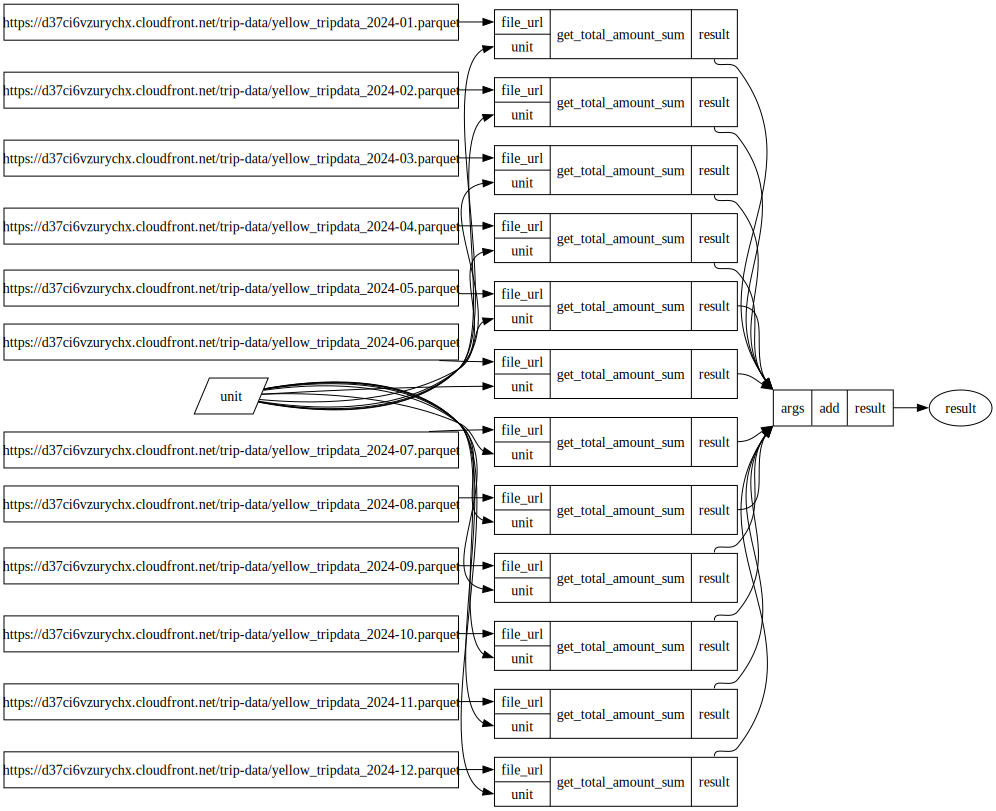

In [8]:
get_graph_image(nyc_yellow_taxi_fare_total_for_year.to_graph(year=2024).to_dot())

If we only want to see the node relations, we can pass the arguments `no_input`, `no_const`, and `no_output` to make the graph less noisy:

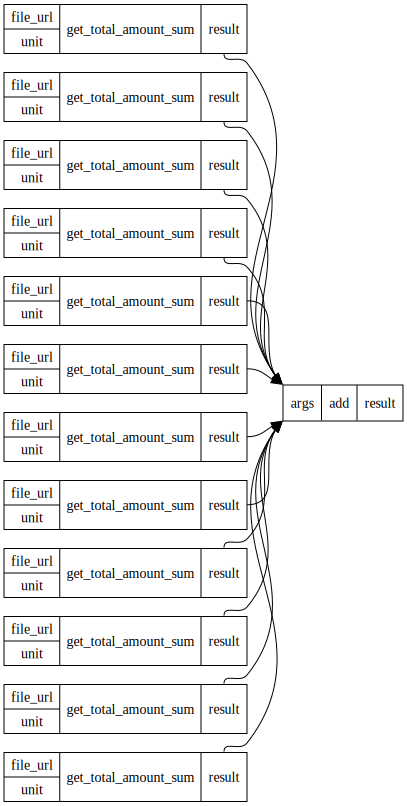

In [9]:
get_graph_image(
    nyc_yellow_taxi_fare_total_for_year.to_graph(year=2024).to_dot(
        no_input=True, no_const=True, no_output=True
    )
)

Although not very useful, we can also generate and visualize a graph from a `delayed` function:

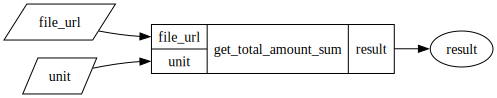

In [10]:
get_graph_image(get_total_amount_sum.to_graph().to_dot())

## Nested graphs

What if we want to compose multiple graphs into one bigger graph? We can do that by nesting graph functions!

In [11]:
URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02}.parquet"


@graph
def nyc_yellow_taxi_fare_total_by_year(years, unit):
    """
    Calculate the total fare amount for multiple years

    :param years: A list of years for which to calculate the total fare amount
    :param unit: The unit to divide the total amount sum by
    :return: Total fare amounts for the given years
    """
    results = []

    for year in years:
        results.append(year)
        results.append(nyc_yellow_taxi_fare_total_for_year(year, unit))

    return collect_result(*results)

You'll notice that when we visualize the graph that the `nyc_yellow_taxi_fare_total_for_year` function is now a node in the graph:

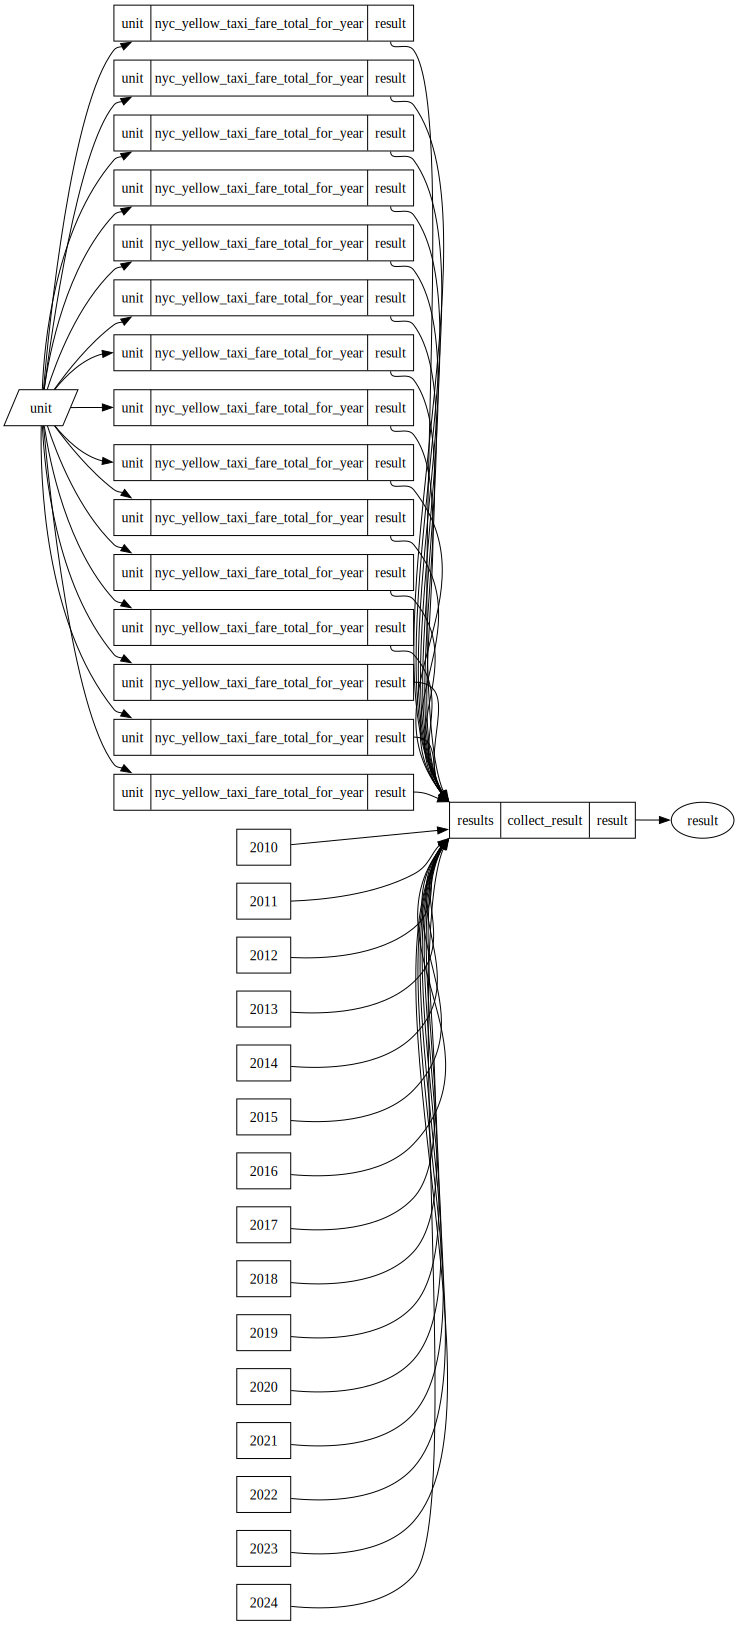

In [12]:
get_graph_image(
    nyc_yellow_taxi_fare_total_by_year.to_graph(years=range(2010, 2025)).to_dot()
)

## Executing graphs

First, we need to generate the task graph:



In [13]:
task_graph, keys = nyc_yellow_taxi_fare_total_by_year.to_graph(
    years=range(2010, 2025)
).to_dict(unit=1_000_000)

Using `pargraph.GraphEngine`:

In [14]:
from pargraph import GraphEngine

graph_engine = GraphEngine()
graph_engine.get(task_graph, keys)

[2010    1918.338539
 2011    2162.509784
 2012    2252.376023
 2013    2539.675245
 2014    2540.022480
 2015    2350.830822
 2016    2147.965770
 2017    1854.894338
 2018    1690.276359
 2019    1623.638299
 2020     454.079334
 2021     608.700671
 2022     859.397945
 2023    1090.383412
 2024    1145.869126
 dtype: float64]